### Start a spark session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.jars.packages", "io.delta:delta-sharing-spark_2.12:3.3.0") \
    .getOrCreate()

:: loading settings :: url = jar:file:/Users/jeremiah.agboola/Library/Python/3.9/lib/python/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/jeremiah.agboola/.ivy2/cache
The jars for the packages stored in: /Users/jeremiah.agboola/.ivy2/jars
io.delta#delta-sharing-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-22902a32-663a-42f1-8348-536be2a70136;1.0
	confs: [default]
	found io.delta#delta-sharing-spark_2.12;3.3.0 in central
	found io.delta#delta-spark_2.12;3.3.0 in central
	found io.delta#delta-storage;3.3.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found io.delta#delta-sharing-client_2.12;1.2.2 in central
	found org.apache.httpcomponents#httpclient;4.5.14 in local-m2-cache
	found org.apache.httpcomponents#httpcore;4.4.16 in local-m2-cache
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.11 in local-m2-cache
:: resolution report :: resolve 135ms :: artifacts dl 7ms
	:: modules in use:
	commons-codec#commons-codec;1.11 from local-m2-cache in [default]
	commons-logging#commons-logg

### List Tables
Use the provided config

In [2]:
import delta_sharing
config = "config.share"
client = delta_sharing.SharingClient(config)
client.list_all_tables()

/Users/jeremiah.agboola/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[Table(name='ev3_device_data', share='start_hack_2025', schema='start_hack_2025'),
 Table(name='cc_api_logs', share='start_hack_2025', schema='start_hack_2025'),
 Table(name='ev3_dataprofile', share='start_hack_2025', schema='start_hack_2025')]

### Table 1
Energyvalve 3 dataprofile describing the datapoints found in the device data table.

In [3]:
df = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.ev3_dataprofile").limit(3)
df.toPandas()

25/03/20 19:24:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,access,basetype,description,format,name,privacy,restriction,definedBy,unit
0,evcloud.00009,r,int,Valve Type,application/vnd.belimo.enum;0|1,ValveType,False,uint8,evcloud/1.2,None
1,evcloud.10,r,int,DN Size of Valve,None,DN_Size,False,int32,evcloud/1.2,None
2,evcloud.100,r,real,Relative Flow in %,None,RelFlow_Fb_Rel2Vmax,False,"[-2147483.648,2147483.647]",evcloud/1.2,percent


### Table 2
Energyvalve 3 device data. **Big data** list of timeseries samples for devices. Devices are differentiated by the **device_id** column.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, collect_list, struct, avg
import json

# Initialize Spark session
spark = SparkSession.builder.appName("DeviceDataProcessing").getOrCreate()

# Load dataset
df_filtered = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.ev3_device_data").limit(86018) 

# Compute efficiency and consumption with error handling
df_with_result = df_filtered.select(
    col("device_id"),
    col("AbsPower_Fb_W"),
    col("Cooling_E_J"),
    col("Heating_E_J"),
    col("year_month_day"),
    when(
        col("AbsPower_Fb_W") != 0,  # Avoid division by zero
        col("Cooling_E_J") / col("AbsPower_Fb_W")
    ).otherwise(0).alias("cool-coeff"),
    when(
        col("AbsPower_Fb_W") != 0,  # Avoid division by zero
        col("Heating_E_J") / col("AbsPower_Fb_W")
    ).otherwise(0).alias("heat-coeff"),
    (((col("Heating_E_J") + col("Cooling_E_J"))/3600000)*0.1308).alias("cost_baseline")
)

# Collect device_ids
device_ids = df_with_result.select("device_id").distinct().rdd.flatMap(lambda x: x).collect()

# Prepare a dictionary to hold the final JSON structure
final_json = {}

# Loop over each device_id to create the corresponding key-value pair
for device_id in device_ids:
    # Filter data for the current device_id
    filtered_df = df_with_result.filter(df_with_result.device_id == device_id)
    
    # Collect the data for the current device_id as a list of rows (convert to JSON)
    records = filtered_df.collect()
    device_data = [row.asDict() for row in records]
    
    # Add the device_id as the key and the records list as the value
    final_json[str(device_id)] = device_data

# Write the final JSON object to a file in the current working directory
with open("./device_data.json", "w") as outfile:
    json.dump(final_json, outfile, indent=4)

print("JSON file with device data saved successfully!")

25/03/20 19:24:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/03/20 19:24:47 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


JSON file with device data saved successfully!


### Plot
Heat Exchanger Characteristic

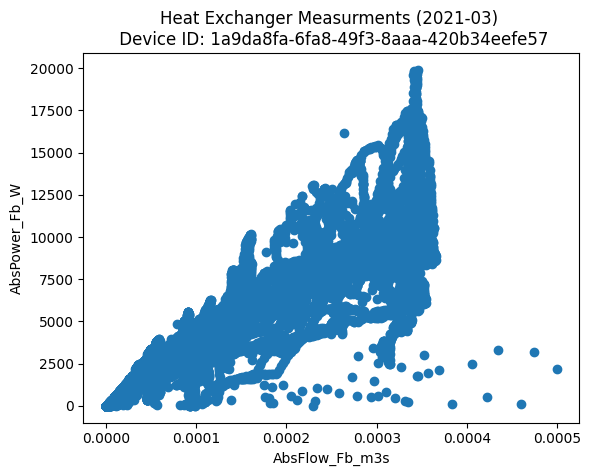

In [5]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

device_id = "1a9da8fa-6fa8-49f3-8aaa-420b34eefe57"
year_month = "202103"
x = "AbsFlow_Fb_m3s"
y = "AbsPower_Fb_W"
df_data = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.ev3_device_data").filter((col("device_id") == device_id) & (col("year_month") == year_month)).toPandas()
year_month = year_month[:4] + '-' + year_month[4:]
plt.scatter(df_data[x], df_data[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"Heat Exchanger Measurments ({year_month}) \n Device ID: {device_id}")
plt.show()

### Table 3
Cloud api logs describing interactions with our cloud.

In [6]:
df = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.cc_api_logs").limit(3)
df.toPandas()

,api,class,cloudEnv,component,correlationId,developmentDevice,durationInMs,host,httpStatus,logEnv,...,principal,requestId,requestURI,requestURL,signature,signatureFull,signatureId,threadName,userAgent,timestamp
0,device,None,production,core-cloud,CCB:9ae22714-7c8c-4490-8f07-d5fd7793b6cf,NaN,119,logsearch-lifeline-agent-stateful-0.logsearch-...,401,production,...,None,a3818cc09b0af2d7c72134ca5fa93eda,/device-api/registration,https://connect.g2bcc.com/device-api/registration,None,None,None,http-nio-8080-exec-29,"sharedlogic/3.22.5-0 (bsp 10.8.0-0, model 1.2....",2025-01-16 08:45:23.365
1,device,DeviceApiV2DeviceController,production,core-cloud,CCB:fc660e65-b629-4ca1-9adc-ac91cd3fb090,NaN,24,logsearch-lifeline-agent-stateful-0.logsearch-...,200,production,...,4d284824-f2dc-4e47-9641-9c4bd115fbab,db0062793fb9ee45787e4588891f15dc,/device-api/v2/devices/8acbcbb2-0649-429b-b09b...,https://connect.g2bcc.com/device-api/v2/device...,DeviceApiV2DeviceController.getTaskList(String...,ch.belimo.cloud.server.deviceapi.v2.DeviceApiV...,111elm3x3ote5,http-nio-8080-exec-93,,2025-01-16 08:45:23.450
2,device,DeviceApiV2DeviceController,production,core-cloud,CCB:6cb197c0-6be1-4e49-82f4-90539ab6ded2,NaN,23,logsearch-lifeline-agent-stateful-0.logsearch-...,200,production,...,d68a34f0-379c-4534-84e9-0278b8539c11,93df335640a41a3e4b1ecc00a4e58304,/device-api/v2/devices/fec4211e-1d9a-41c8-820d...,https://connect.g2bcc.com/device-api/v2/device...,DeviceApiV2DeviceController.getTaskList(String...,ch.belimo.cloud.server.deviceapi.v2.DeviceApiV...,111elm3x3ote5,http-nio-8080-exec-146,,2025-01-16 08:45:23.452
